In [1]:
# Standard library
import warnings
import math

# Third party
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras



## Load dataset

In [2]:
df = pd.read_csv(f"../data/VTech/_VTech_merged.csv")

## Dataset information

In [3]:
print(f"Number of workers: {len(df['worker'].unique())}")
for worker, worker_df in df.groupby("worker"):
    print(f"\tWorker {worker}: {len(worker_df['day'].unique())} days"
          f", {len(worker_df['trial'].unique())} trials"
          f", {worker_df['mode'].diff().abs().sum():3.0f} transitions"
          f", {len(worker_df):10,} samples")
print(f"Total number of transitions: {df['mode'].diff().abs().sum()}")


Number of workers: 4
	Worker 1: 1 days, 5 trials,  28 transitions,  1,448,215 samples
	Worker 2: 3 days, 4 trials,  68 transitions,  1,351,866 samples
	Worker 3: 1 days, 2 trials,  59 transitions,    859,697 samples
	Worker 4: 1 days, 6 trials, 110 transitions,  1,646,663 samples
Total number of transitions: 266.0


## Building the TF Dataset

Stack consecutive `WINDOW_SIZE` samples with a sliding window, use the least sample for the target variable.
Do not overlap different workers/trials.
The resulting samples in the dataset are: `(WINDOW_SIZE, N_FEATURES) -> (1,)`

In [4]:
first_feature = "orientation_T8_q0"
WINDOW_SIZE = 50
    
def make_windowed_dataset(ds, window_size, shift=1):
    windows = ds.window(window_size, shift=shift)

    def sub_to_batch(sub):
        return sub.batch(window_size, drop_remainder=True)

    def add_labels(batch):
      return batch[:, :-1], batch[-1, -1]
    
    windows = windows.flat_map(sub_to_batch)
    return windows.map(add_labels)


ds = None
for trial_id, trial_data in df.groupby(["worker", "trial"]):
    ds_trial = make_windowed_dataset(
        tf.data.Dataset.from_tensor_slices(trial_data.loc[:,first_feature:].values),
        window_size=WINDOW_SIZE
    )
    if ds is None:
        ds = ds_trial
    else:
        ds = ds.concatenate(ds_trial)

## Model 

In [9]:
normalization = tf.keras.layers.experimental.preprocessing.Normalization()
normalization.adapt(ds.take(100000).map(lambda x, y: x))


model = keras.Sequential(
    [
        keras.layers.Input(shape=(WINDOW_SIZE, 66)),
        normalization,
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu", name="layer1"),
        keras.layers.Dense(16, activation="relu", name="layer2"),
        keras.layers.Dense(1, activation= "sigmoid" ),
    ]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 50, 66)            133       
_________________________________________________________________
flatten_3 (Flatten)          (None, 3300)              0         
_________________________________________________________________
layer1 (Dense)               (None, 64)                211264    
_________________________________________________________________
layer2 (Dense)               (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 212,454
Trainable params: 212,321
Non-trainable params: 133
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy, 
              metrics=['accuracy'])
model.fit(ds.shuffle(buffer_size=2**18).batch(128), epochs=10)

Epoch 1/10
41451/41451 [==============================] - 637s 15ms/step - loss: 0.1044 - accuracy: 0.9602
Epoch 2/10
41451/41451 [==============================] - 620s 15ms/step - loss: 0.1081 - accuracy: 0.9608
Epoch 3/10
41451/41451 [==============================] - 619s 15ms/step - loss: 0.1311 - accuracy: 0.9531
Epoch 4/10
41451/41451 [==============================] - 618s 15ms/step - loss: 0.1302 - accuracy: 0.9535
Epoch 5/10
41451/41451 [==============================] - 616s 15ms/step - loss: 0.1215 - accuracy: 0.9551
Epoch 6/10
41451/41451 [==============================] - 612s 15ms/step - loss: 0.1190 - accuracy: 0.9566
Epoch 7/10
41451/41451 [==============================] - 615s 15ms/step - loss: 0.1264 - accuracy: 0.9556
Epoch 8/10
41451/41451 [==============================] - 620s 15ms/step - loss: 0.1278 - accuracy: 0.9544
Epoch 9/10
41451/41451 [==============================] - 621s 15ms/step - loss: 0.1171 - accuracy: 0.9592
Epoch 10/10
41451/41451 [============

In [12]:
p = model.predict(ds.batch(128))

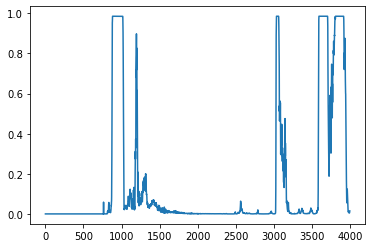

In [44]:
plt.plot(p[:4000])

In [14]:
import matplotlib.pyplot as plt


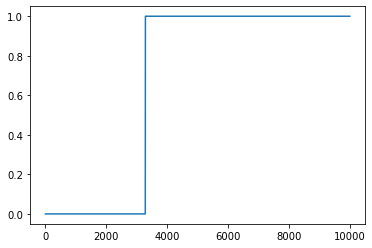

In [46]:
plt.plot(df.iloc[:10000,-1])

In [51]:
y = np.array([y for _, y in ds])

In [ ]:
yhat = p>0.5

In [52]:
len(y), len(yhat)

(5305608, 5305608)

In [63]:
np.sum(y == np.asarray(yhat, dtype=np.float).flatten()) / len(y)

0.8280760659287305

In [70]:
stereo = np.vstack((np.asarray(yhat, dtype=np.float).flatten(), y)).T
stereo

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [73]:
from scipy.io import wavfile
wavfile.write("vtech_preds.wav", 25, stereo)